# Homework 1 - Diagnostic
### Machine Learning for Public Policy
#### Kyle Schindl

## Data Acquisition and Analysis:

In [1]:
import pandas as pd
from sodapy import Socrata
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np

In [2]:
'''
We use the Socrata Open Data API for downloading crime data in Chicago
filtering for crimes ocurring in 2017 and 2018
'''

client = Socrata("data.cityofchicago.org", None)
results = client.get("6zsd-86xi", where="date between '2017-01-01T00:00:00' and '2018-12-31T23:59:59'", limit=600000)
crime = pd.DataFrame.from_records(results)
crime.date = pd.to_datetime(crime.date)

In [3]:
'''
Next, in order to better interpret the results we use the SODA API
to create a dictionary mapping the community area int to its
corresponding neighborhood name. Note that there are three extraneous
community areas labeled '0' in the original dataset, which we map to
O'Hare, based on the address of the incident.
'''

neighborhoods = client.get("igwz-8jzy", select="AREA_NUMBE, COMMUNITY")
neighborhood_dict = pd.DataFrame.from_records(neighborhoods, index="AREA_NUMBE").to_dict()["COMMUNITY"]
neighborhood_dict['0'] = "OHARE"
crime.community_area = crime.community_area.replace(neighborhood_dict)

In [4]:
'''
To begin generating summary statistics, we check the 15 largest crimes
for 2017 and 2018
'''

crime_groups = crime.groupby([crime.date.dt.year, "description"]).description.count()
crime_groups.groupby(level="date").nlargest(15).reset_index(level=0, drop=True)

date  description                        
2017  SIMPLE                                 29076
      $500 AND UNDER                         24514
      DOMESTIC BATTERY SIMPLE                23818
      OVER $500                              15347
      TO VEHICLE                             14547
      TO PROPERTY                            13842
      FROM BUILDING                          10661
      RETAIL THEFT                           10459
      AUTOMOBILE                              9855
      FORCIBLE ENTRY                          7506
      FINANCIAL IDENTITY THEFT OVER $ 300     5016
      AGGRAVATED: HANDGUN                     4996
      UNLAWFUL ENTRY                          4594
      ARMED: HANDGUN                          4549
      CREDIT CARD FRAUD                       3937
2018  SIMPLE                                 29680
      $500 AND UNDER                         24794
      DOMESTIC BATTERY SIMPLE                24259
      OVER $500                         

In [5]:
def check_neighborhood(dataframe, n=5, neighborhood=None):
    '''
    Identifies the top n crimes reported in a chosen set of neighborhoods in 2017 and 2018 for
    comparison across time, neighborhoods. Default call will return top 5 crimes for all neighborhoods
    
    Inputs:
        dataframe
        n (int): desired top n crimes
        neighborhood (list): list of neighborhoods to report

    Returns:
        series - top n crimes for specified neighborhoods
    '''
    areas = dataframe.groupby(["community_area", dataframe.date.dt.year, "description"]).description.count()
    groups = areas.groupby(["community_area","date"]).nlargest(n).reset_index(level=[1,2], drop=True)
    
    if neighborhood:
        return groups[neighborhood]
    
    return groups

In [6]:
'''
In order to begin identifying differences in crime between neighborhoods,
we do a sample run of check_neighborhoods on Hyde Park and Woodlawn.
'''
check_neighborhood(crime, 5, ['HYDE PARK', 'WOODLAWN'])

community_area  date  description            
HYDE PARK       2017  $500 AND UNDER             227
                      SIMPLE                     166
                      OVER $500                  149
                      RETAIL THEFT               120
                      FROM BUILDING              110
                2018  $500 AND UNDER             247
                      TO VEHICLE                 224
                      OVER $500                  150
                      SIMPLE                     150
                      RETAIL THEFT               139
WOODLAWN        2017  DOMESTIC BATTERY SIMPLE    452
                      SIMPLE                     426
                      $500 AND UNDER             340
                      TO PROPERTY                287
                      FORCIBLE ENTRY             206
                2018  DOMESTIC BATTERY SIMPLE    413
                      SIMPLE                     400
                      $500 AND UNDER             291


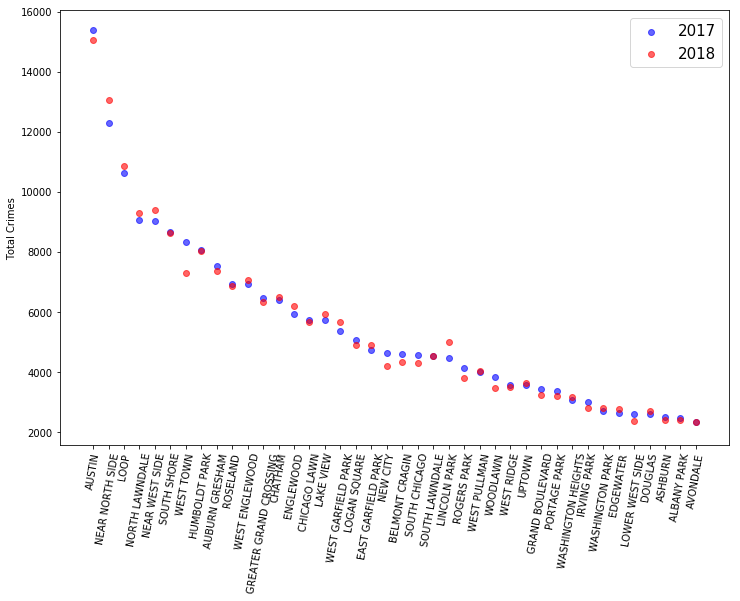

In [7]:
'''
Next, we visualize the total number of crimes in both 2017 and 2018 by
neighborhood, sorted from highest to lowest
'''

top_crimes_2017 = crime[crime.date.dt.year == 2017].groupby("community_area").description.count().sort_values(ascending=False).head(40)
top_crimes_2018 = crime[crime.date.dt.year == 2018].groupby("community_area").description.count().sort_values(ascending=False).head(40)

plt.figure(figsize=(12,8))
plt.scatter(top_crimes_2017.index, top_crimes_2017, color='b', alpha=0.6, label="2017")
plt.scatter(top_crimes_2018.index, top_crimes_2018, color='r', alpha=0.6, label="2018")
plt.ylabel("Total Crimes")
plt.xticks(rotation=80)
plt.legend(prop={'size': 15})
plt.show()

In [8]:
'''
To further investigate the change in crime between 2017 and 2018
we calculate the percent change and difference between crimes for
each neighborhood
'''

change = crime.groupby([crime.date.dt.year, "community_area"]).description.count().unstack().T.reset_index()
change = change.rename(columns={2017: "2017", 2018: "2018"})
change['pct_change'] = 100 * (change['2018'] - change['2017']) / change['2017']
change['diff'] = change['2018'] - change['2017']
change.head(10)

date,community_area,2017,2018,pct_change,diff
0,ALBANY PARK,2480,2416,-2.580645,-64
1,ARCHER HEIGHTS,849,817,-3.769140,-32
2,ARMOUR SQUARE,1020,1014,-0.588235,-6
3,ASHBURN,2510,2405,-4.183267,-105
4,AUBURN GRESHAM,7527,7370,-2.085824,-157
5,AUSTIN,15386,15042,-2.235799,-344
6,AVALON PARK,1283,1162,-9.431021,-121
7,AVONDALE,2348,2330,-0.766610,-18
8,BELMONT CRAGIN,4605,4359,-5.342020,-246
9,BEVERLY,898,911,1.447661,13


In [9]:
'''
We find that the median neighborhood in Chicago had a
-1.06% decrease in crime between 2017 and 2018 and
18 fewer crimes overall
'''
change.describe().loc['50%', ['pct_change', 'diff']]

date
pct_change    -1.055409
diff         -18.000000
Name: 50%, dtype: float64

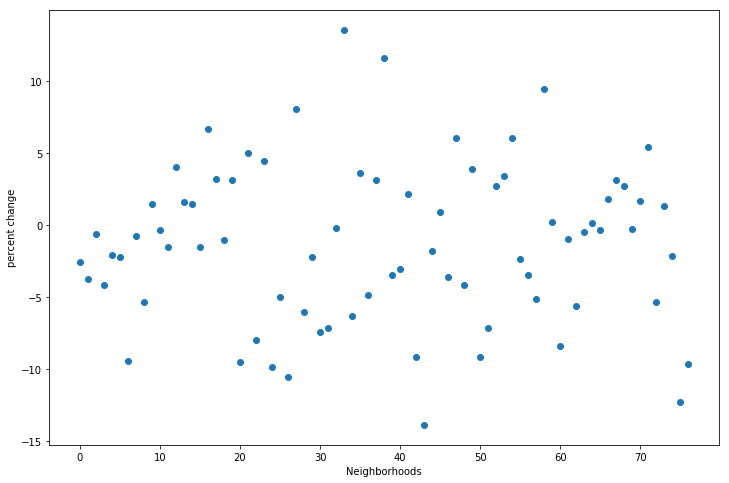

In [10]:
'''
Visualizing the percent change in crimes for each neighborhood
between 2017 and 2018
'''

plt.figure(figsize=(12,8))
plt.scatter(change['pct_change'].index, change['pct_change'])
plt.ylabel("percent change")
plt.xlabel("Neighborhoods")
plt.show()

# *Data Augmentation and APIs:*

In [11]:
import geopandas as gpd
from shapely.geometry import Point, Polygon
from census import Census
from matplotlib import pylab

In [12]:
'''
Downloading data through the ACS API
using the Census Python wrapper
'''

acs_key = "1006a1e4567f2582e57c3affbab639c19c930271"
acs = Census(acs_key, year=2017)
req = acs.acs5.get(('NAME', 'B01003_001E', 'B02001_002E', 'B02001_003E',
                    'B02001_005E', 'B03003_003E', 'B19013_001E',
                    'B25010_002E', 'B25010_003E'), 
                   {'for': 'block group:*', 'in': 'state:17 county:031'})

demographics = pd.DataFrame(req)
demographics = demographics.rename(columns={
                            "B01003_001E": "total_population", 
                            "B02001_002E": "white_alone",
                            "B02001_003E": "black_alone",
                            "B02001_005E": "asian_alone",
                            "B03003_003E": "hispanic_latino",
                            "B19013_001E": "median_household_income",
                            "B25010_002E": "avg_household_size_owner",
                            "B25010_003E": "avg_household_size_renter"})

In [13]:
'''
In order to merge the crime data with the census data, we
manually download block group shapefiles from the census website,
in order to conduct a spatial merge between block groups and the
given location of a crime.
'''

blocks = gpd.read_file("cb_2016_17_bg_500k/cb_2016_17_bg_500k.shp")

#Here we create Point objects for the spatial merge and cull
#approximately 5,000 rows missing location data
crime = crime[~crime.location.isnull()]
crime['point'] = crime.location.apply(lambda x:
                 Point(x['coordinates'][0], x['coordinates'][1]))

crime = gpd.GeoDataFrame(crime, geometry='point')
#Setting the crime crs to match the census crs
crime.crs = {'init': 'epsg:4269'}
crime = gpd.sjoin(crime, blocks, how='left', op='intersects')

In [14]:
#Turning crime back into a pandas dataframe
crime = pd.DataFrame(crime)

#Now we create an block group id to merge the crime and 
#census dataframes on
crime['bgid'] = (crime.STATEFP + crime.COUNTYFP +
                 crime.TRACTCE + crime.BLKGRPCE)

demographics['bgid'] = (demographics.state + demographics.county
                        + demographics.tract + demographics['block group'])

#removing approximately 100 rows missing block group data
crime = crime[~crime.bgid.isnull()]

crime = pd.merge(crime, demographics, how='left', on='bgid')

In [15]:
#removing 15 rows with no demographic match
crime = crime[~crime.total_population.isnull()]

#Setting negative values representing NaNs to NaN
mask = crime._get_numeric_data()
mask[mask < 0] = np.nan

In [16]:
'''
Converting race related demographics to percentages for
more intuitive analysis
'''

for col in ['white_alone', 'black_alone', 'asian_alone', 'hispanic_latino']:
    crime[col] = round(100 * (crime[col] / crime['total_population']), 2)

In [17]:
#We now select columns of interest to retain for analysis
crime = crime[['community_area', 'block', 'date', 'description', 'district', 'location_description',
               'primary_type', 'ward', 'bgid', 'total_population', 'white_alone',
               'black_alone', 'asian_alone', 'hispanic_latino', 'median_household_income',
               'avg_household_size_owner', 'avg_household_size_renter']]

In [18]:
def describe_crime(dataframe, crime, primary_type=False):
    '''
    Returns the median description of demographic data for
    given block groups in 2017, 2018 for a given crime
    
    Inputs:
        dataframe
        crime (str)
    
    Returns:
        dataframe
    '''
    if primary_type:
        blocks = dataframe[dataframe.primary_type == crime]
    else:
        blocks = dataframe[dataframe.description.str.contains(crime)]
    
    block_groups = blocks.groupby(blocks.date.dt.year).median().T
    block_groups.columns.name = "demographic"
    
    return block_groups

In [19]:
'''
We observe virtually no change in block groups reporting
a "Battery" between 2017 and 2018
'''
describe_crime(crime, "BATTERY")

demographic,2017,2018
total_population,1201.00,1206.50
white_alone,5.65,6.08
black_alone,88.33,87.83
asian_alone,0.00,0.00
hispanic_latino,4.80,4.80
median_household_income,33750.00,33750.00
avg_household_size_owner,2.88,2.87
avg_household_size_renter,2.71,2.70


In [20]:
'''
There is a stark difference in block groups reporting a
"Homicide" between 2017 and 2018. Namely, they are in
denser block groups, less white, more black, and less hispanic
'''
describe_crime(crime, "HOMICIDE")

demographic,2017,2018
total_population,887.500,1517.00
white_alone,30.700,13.56
black_alone,30.335,68.34
asian_alone,4.940,1.12
hispanic_latino,21.780,12.75
median_household_income,35528.500,36250.00
avg_household_size_owner,2.385,3.35
avg_household_size_renter,2.615,3.18


In [21]:
'''
When comparing block groups reporting "Deceptive Practice" (below)
and "Sex Offense" we note that block groups reporting
"Deceptive Practice" are generally whiter, and wealthier,
reporting nearly $20,000 more in median household income and
a fifteen point increase in whiteness
'''
describe_crime(crime, "SEX OFFENSE", True)

demographic,2017,2018
total_population,1311.00,1275.00
white_alone,43.76,48.58
black_alone,16.07,15.96
asian_alone,1.02,1.06
hispanic_latino,10.57,9.91
median_household_income,40868.00,44634.00
avg_household_size_owner,2.78,2.68
avg_household_size_renter,2.53,2.42


In [22]:
describe_crime(crime, "DECEPTIVE PRACTICE", True)

demographic,2017,2018
total_population,1386.00,1400.00
white_alone,58.02,57.95
black_alone,13.16,13.16
asian_alone,3.37,3.62
hispanic_latino,8.62,7.97
median_household_income,58000.00,58819.00
avg_household_size_owner,2.46,2.43
avg_household_size_renter,2.15,2.12


# *Analysis and Communication*:

We find that crime has generally decreased in Chicago from 2017 to 2018. Crime decreased in 47 of Chicago's 77 neighborhoods, and overall by 0.68%. To make more nuanced statements about crime, one must focus in on a local, neighborhood level. Because different neighborhoods have different demographic traits, the type and amount of crime differs (for example, depending on characteristics such as median income, household size, or education).

After analyzing the alderman's statistics, we find that they are largely incorrect. Robberies, burglaries, and motor vehicle theft were all down when compared to the same period in 2017. Although aggravated batteries did have a 5.71% increase, the alderman was incorrect by over 100 percentage points! Similarly, when comparing overall crime year-to-date between 2017 and 2018 there was also a decrease.

In [23]:
def change_in_period(dataframe, crime, date):
    periods = []
    for year in ['2017-', '2018-']:
        periods.append(dataframe[(dataframe.date.between(year + date[0], year + date[1]))
              & (dataframe.primary_type == crime)].shape[0])
    
    return round(100 * (periods[1] - periods[0]) / periods[0], 2)

In [24]:
for col in ["ROBBERY", "BURGLARY", "MOTOR VEHICLE THEFT"]:
    print(col + ": ", change_in_period(crime, col, ['07-01T00:00:00', "07-26T00:00:00"]))

ROBBERY:  -13.25
BURGLARY:  -6.13
MOTOR VEHICLE THEFT:  -13.64


In [25]:
agg_mask = crime[crime.description.str.contains("AGG")]
print("BATTTERY: ", change_in_period(agg_mask, "BATTERY", ['07-01T00:00:00', "07-26T00:00:00"]))

BATTTERY:  5.71


In [26]:
ytd_2017 = crime[crime.date.between('2017-01-01T00:00:00', '2017-07-26T00:00:00')].description.agg('count')
ytd_2018 = crime[crime.date.between('2018-01-01T00:00:00', '2018-07-26T00:00:00')].description.agg('count')

round( 100 * (ytd_2018 - ytd_2017) / ytd_2017, 2)

-1.04

Additionally, the alderman is running a high risk of cherry-picking their statistics to fit an agenda. As we see from the graph below, crime in Chicago is very cyclical. Comparing crime between time periods could potentially misrepresent the actual patterns in the data depending on where each year is in the cycle when compared.

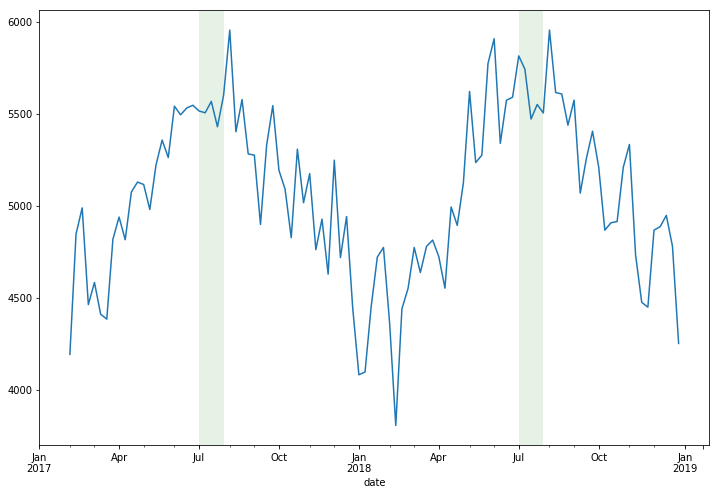

In [27]:
dates = crime[crime.date > '2017-02-01T00:00:00']
graph = dates.description
graph.index = dates.date

plt.figure(figsize=(12,8))
graph.resample("W-MON").count().plot()

pylab.axvspan('2017-07-01T00:00:00', "2017-07-26T00:00:00", facecolor='g', alpha=0.1)
pylab.axvspan('2018-07-01T00:00:00', "2018-07-26T00:00:00", facecolor='g', alpha=0.1)
pylab.show()

If we were to provide 5 key findings that could be used to deal with crime in Chicago they would be:

1. Identify neighborhoods in need of additional resources. Some neighborhoods such as Austin, Near North Side, and Loop report a disproportionate amount of crimes compared to other neighborhoods.
2. Crime in Chicago is very cyclic. It may be possible to optimize resource allocation depending on the time of the year.
3. Certain neighborhoods may tend to have different kinds of crimes reported. For example, neighborhoods reporting "Deceptive Practice" tend to have a high median household income.
4. Nearly 100% of the top crimes in 2017 were the same top crimes of 2018. Therefore, targeting these specific crimes may have large benefits in crime reduction.
5. Some crimes do not exhibit stable trends over time (e.g. "Homocide") and could potentially be more difficult to target and reduce. More stable crimes such as "Battery" may have more systemic roots that can be focused on.

A few potential caveats of our analysis:
- We have only used two years of data (2017, 2018), so it is possible that these results are not representative of a longer time trend
- Our data is depedent on the reporting of the Chicago police. Any biases or misrepresentation of reporting will also bias our analysis.
    - Notably, our data contains only reported crimes
- Just because data is reported from a certain neighborhood does not necessarily imply that the residents of said neighborhood were involved.

# *Conditional Probabilities:*

In [28]:
'''
A:

By checking the address in the Chicago Open Data Portal we are
able to find its block id. We find that 'Theft' is the most likely
crime from the given block group encapsulating the address. The
probabilities of each crime are given below.

'''

call_bgid = '170313301004'
michigan = crime[crime.bgid == call_bgid].primary_type.value_counts()
michigan.apply(lambda x: round(100 * x / michigan.sum(), 2))

THEFT                               29.43
BATTERY                             18.89
DECEPTIVE PRACTICE                  11.95
CRIMINAL DAMAGE                      8.10
OTHER OFFENSE                        7.07
ASSAULT                              5.78
ROBBERY                              3.86
MOTOR VEHICLE THEFT                  3.73
CRIMINAL TRESPASS                    3.73
BURGLARY                             3.21
OFFENSE INVOLVING CHILDREN           0.77
SEX OFFENSE                          0.77
CRIM SEXUAL ASSAULT                  0.64
NARCOTICS                            0.51
PUBLIC PEACE VIOLATION               0.51
WEAPONS VIOLATION                    0.39
INTIMIDATION                         0.26
ARSON                                0.13
OBSCENITY                            0.13
INTERFERENCE WITH PUBLIC OFFICER     0.13
Name: primary_type, dtype: float64

In [29]:
'''
B:

We see that because there are more calls relating to theft
coming from Garfield Park, it is more likely the call came from there
than Uptown. However, it is worth noting that there is an East and
West Garfield Park, both of which have fewer reports of theft than
Uptown. If we were comparing either East or West Garfield Park alone
with Uptown, Uptown would have a higher likelihood.

We find it is 0.45% more likely for a theft call to come from
Garfield Park than Uptown.
'''

theft = crime[crime.primary_type == 'THEFT']
groups = theft.groupby('community_area').description.agg('count')

uptown = 100 * groups['UPTOWN'] / groups.sum()
garfield = 100 * (groups['EAST GARFIELD PARK'] +
                       groups['WEST GARFIELD PARK']) / groups.sum()
print("Uptown: ", groups['UPTOWN'])
print("Garfield Park: ", groups['EAST GARFIELD PARK'] +
                         groups['WEST GARFIELD PARK'])

print("Percentage difference: ", round(garfield - uptown, 2), "%")

Uptown:  1907
Garfield Park:  2475
Percentage difference:  0.45 %


In [30]:
'''
C:

To find the likelihood of a "Battery" call coming from Garfield Park
or Uptown, we employ Baye's Rule and find that a "Battery"
call is 23.08% less likely to come from Garfield Park versus Uptown
'''

garfield_prob = (100 / 600) * (600 / 1000) / (260 / 1000)
uptown_prob = (160 / 400) * (400 / 1000) / (260 / 1000)

round(100 * (garfield_prob - uptown_prob), 2)

-23.08